# CodEbot
-------------------------------

**Contributers:** Nguyen Vuong, Tam Luong <br>
**Tutor:** Hung Nguyen


# Introduction

## Workflow
<div style="text-align: center;">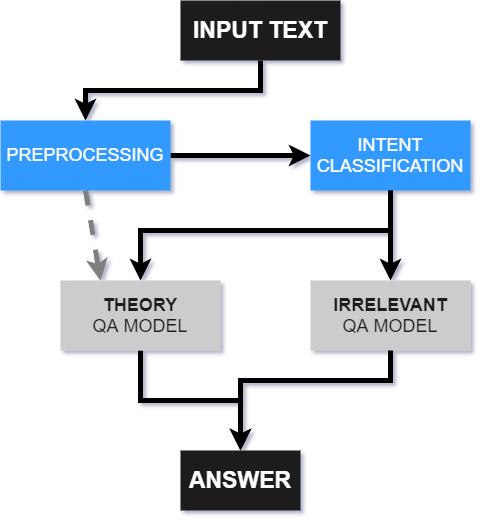</div>


# Preprocessing

- **Libraries use for this stage:** sklearn, underthesea, VietnameseTextNormalizer <br>
- **Steps:**
    - Normalize Vietnamese document (spell, syntax, ...)
    - Converting to lower case
    - Word tokenizing using Vietnamese work tokenizer of underthesea
    - Word embedding using tf-idf vectorizer of sklearn
- **Pipeline:**
<div style="text-align:center;">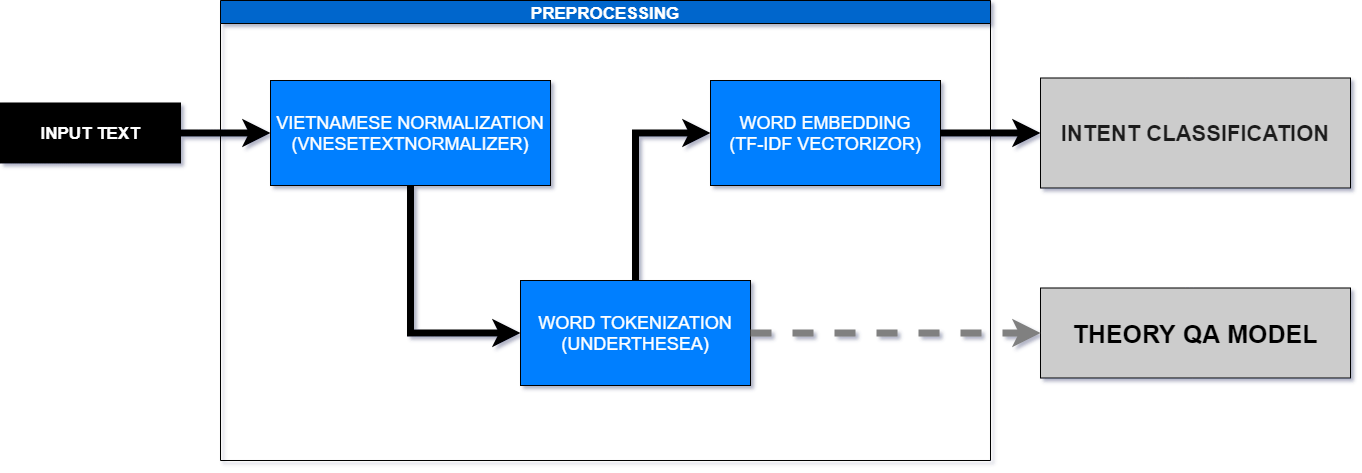</div>


## Import libraries

In [1]:
import os
import errno
import shutil
import time
import random
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import word_tokenize

import joblib

## Define Preprocessing

In [2]:
class Preprocessing:
    def __init__(self, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, 
                 lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, 
                 token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, 
                 vocabulary=None, binary=False, dtype=np.float64, norm='l2', use_idf=True, smooth_idf=True, 
                 sublinear_tf=False):
        if (tokenizer == None):
            self._tokenizer = word_tokenize
        else:
            self._tokenizer = tokenizer
        
        self._vectorizer = TfidfVectorizer(
            input=input, encoding=encoding, decode_error=decode_error, strip_accents=strip_accents, 
            lowercase=lowercase, preprocessor=preprocessor, tokenizer=self._tokenizer, analyzer=analyzer, 
            stop_words=stop_words, token_pattern=token_pattern, ngram_range=ngram_range, 
            max_df=max_df, min_df=min_df, max_features=max_features, vocabulary=vocabulary, binary=binary, 
            dtype=dtype, norm=norm, use_idf=use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)
        
    def fit(self, df):
        self._vectorizer.fit(self.optional_preprocess(df))
        return self
    
    def fit_transform(self, df):
        return self._vectorizer.fit_transform(self.optional_preprocess(df))
        
    def transform(self, df):
        """
        Vectorize Pandas DataFrame
        """
        return self._vectorizer.transform(self.optional_preprocess(df))
    
    def optional_preprocess(self, df):
        return df.apply(lambda q: re.sub('[cC]\+\+', 'cpp', q))
    
    def save(self, file_name):
        print("Saving model to ", file_name)
        return joblib.dump(self, file_name)
        
    @staticmethod
    def load(file_name):
        if (isinstance(file_name, str) and os.path.isfile(file_name)):
            self = joblib.load(file_name)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), file_name)
        return self

## Import dataset

In [3]:
if (os.path.basename(os.getcwd()) != "CodEbot"):
    os.chdir('../')

data = pd.read_csv("./data/data.csv")

X = data.question
y = data[["intent", "context"]]

data.sample(frac=1).head(15)

,intent,context,question
246,disagree,general,"không, tôi không đồng ý"
149,credit_info,general,bạn có thể làm được những gì?
143,compare,py,"Trong python, list và tuple khác nhau như thế ..."
360,other,general,R
216,define,general,Python là gì
397,references,general,tôi có thể tìm tài liệu học lập trình ở đâu?
122,compare,general,Cho biết sự khác nhau giữa linker và linkage
365,other,general,thông tin covid19
352,other,general,khi nào thì em mới chịu yêu anh?
310,help,general,trợ giúp


## Import Programming Corpus

In [4]:
corpus_path = './data/programming_corpus'
corpus = [X]
for name in ['c', 'cpp', 'py']:
    with open(f'{corpus_path}/{name}.txt', 'r', encoding='utf-8') as f:
        tmp = list(filter(lambda s: len(s) , f.read()[1:].replace('.', '\n').split('\n')))
        corpus.append(pd.Series(tmp))

tfidf_data = pd.concat(corpus, ignore_index=True)
tfidf_data

0                                        cậu biết ý tớ đó
1                              câu trả lời thật là bổ ích
2                         câu trả lời thật là bổ ích đó ạ
3                                             chắc là vậy
4                                                chắc thế
                              ...                        
1591    Cách dùng biến __metaclass__ không còn được hỗ...
1592                                   Cú pháp bị loại bỏ
1593              Không còn dấu ``, thay vì đó, dùng repr
1594                       Không còn so sánh <> (dùng !=)
1595                       Không còn các lớp kiểu classic
Length: 1596, dtype: object

## Fit the preprocessing model with dataset and corpus

In [5]:
tfidf__ngram_range = (1, 2)
tfidf__max_df = 1.0
tfidf__min_df = 3

preprocessor = Preprocessing(ngram_range=tfidf__ngram_range, max_df=tfidf__max_df, min_df=tfidf__min_df)
preprocessor.fit(tfidf_data)

preprocessor.save("./model/preprocessing.bin")

c:\python37\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Saving model to  ./model/preprocessing.bin


['./model/preprocessing.bin']

# Intent Classification

- **Libraries use for this stage:** sklearn <br>
- **Model:** LinearSVC
- **Steps:**
    - Splitting pre-processed data into train set and test set for model evaluation.
    - Fitting train set to LinearSVC model.
    - Validating model evaluation on train set and test set with f1 score (micro averaging).

- **Pipeline:**
<div style="text-align:center;">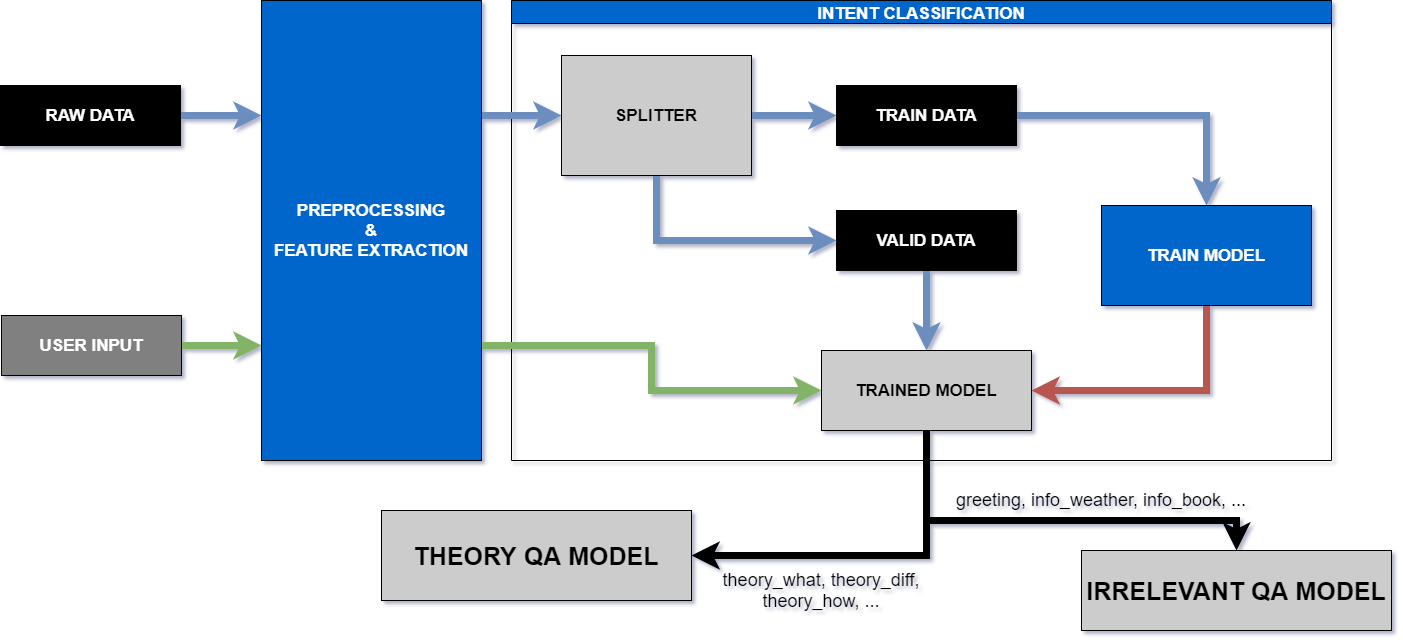</div>


## Import libraries

In [6]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

## Evaluate

In [7]:
def micro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [8]:
pre = Preprocessing.load("./model/preprocessing.bin")

# print(pre._vectorizer.get_feature_names())
X_processed = pre.transform(X)

In [9]:
C = {
    "intent": 0.5,
    "context": 100
}

for column in ["intent", "context"]:
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y[column], test_size=0.2, random_state=46,stratify=y[column])
    
    model = LinearSVC(C=C[column], random_state=46)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"micro f1_score of TRAIN_{column}: {micro_f1_score(pred, y_train)}\n")
    print(f"classification_report of TRAIN_{column}:\n{classification_report(y_train, pred, labels=model.classes_)}")
    print(f"micro f1_score of TEST_{column}: {micro_f1_score(pred_test, y_test)}\n")
    print(f"classification_report of TEST_{column}:\n{classification_report(y_test, pred_test, labels=model.classes_)}")

micro f1_score of TRAIN_intent: 0.9941860465116279

classification_report of TRAIN_intent:
              precision    recall  f1-score   support

       agree       1.00      0.95      0.97        37
       apply       1.00      1.00      1.00        45
     compare       1.00      1.00      1.00        35
 credit_info       1.00      1.00      1.00        19
      define       1.00      1.00      1.00        49
    disagree       1.00      1.00      1.00        26
    greeting       1.00      1.00      1.00        13
        help       1.00      1.00      1.00        41
       other       0.95      1.00      0.97        35
  references       1.00      1.00      1.00        30
         tip       1.00      1.00      1.00        14

    accuracy                           0.99       344
   macro avg       1.00      1.00      0.99       344
weighted avg       0.99      0.99      0.99       344

micro f1_score of TEST_intent: 0.9534883720930233

classification_report of TEST_intent:
       

c:\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Retrain & Save model

In [10]:
for column in ["intent", "context"]:
    model = LinearSVC(C=C[column], random_state=46)
    model.fit(X_processed, y[column])

    pred = model.predict(X_processed)

    print(f"f1_score of AllData_{column}: {micro_f1_score(pred, y[column])}")
    
    joblib.dump(model, f"./model/model_{column}.bin")

f1_score of AllData_intent: 0.9953488372093023
f1_score of AllData_context: 1.0
